In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
df_c = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
df = df_c.copy()

In [4]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')

In [7]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols , num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [10]:
cat_but_car

['customerID']

In [11]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [12]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)



        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
##########################################
     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
##########################################
     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
##########################################
     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
##########################################
                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################
             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
##########################################
                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes 

In [14]:
cat_cols = [col for col in cat_cols if col != "Churn" ]

In [15]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


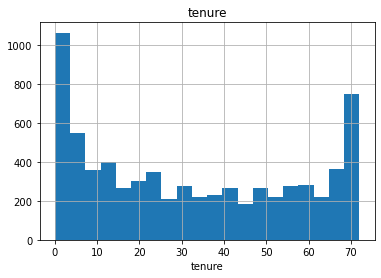

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


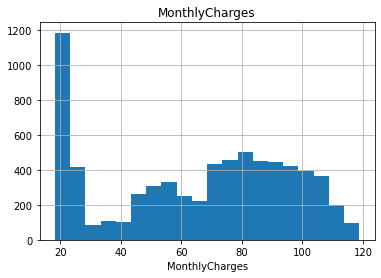

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


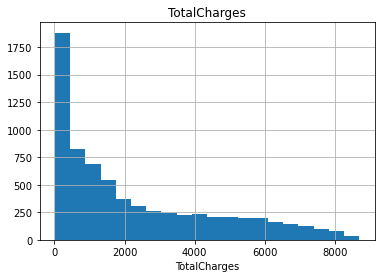

In [16]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)


In [17]:
def target_numeric_analysis (dataframe, target, col):
    return df.groupby(target).agg({col : ["mean","count"]})

In [18]:
for col in num_cols:
    print(target_numeric_analysis(df,"Churn",col))

          tenure      
            mean count
Churn                 
0      37.569965  5174
1      17.979133  1869
      MonthlyCharges      
                mean count
Churn                     
0          61.265124  5174
1          74.441332  1869
      TotalCharges      
              mean count
Churn                   
0      2555.344141  5163
1      1531.796094  1869


In [19]:
def target_categoric_analysis (dataframe, target, col):
    return df.groupby(col).agg({target : ["mean","count"]})

In [20]:
for col in cat_cols:
    print(target_categoric_analysis(df,"Churn",col))

           Churn      
            mean count
gender                
Female  0.269209  3488
Male    0.261603  3555
            Churn      
             mean count
Partner                
No       0.329580  3641
Yes      0.196649  3402
               Churn      
                mean count
Dependents                
No          0.312791  4933
Yes         0.154502  2110
                 Churn      
                  mean count
PhoneService                
No            0.249267   682
Yes           0.267096  6361
                     Churn      
                      mean count
MultipleLines                   
No                0.250442  3390
No phone service  0.249267   682
Yes               0.286099  2971
                    Churn      
                     mean count
InternetService                
DSL              0.189591  2421
Fiber optic      0.418928  3096
No               0.074050  1526
                        Churn      
                         mean count
OnlineSecurity         

In [21]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [22]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [23]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [24]:
for col in num_cols:
    print(col, check_outlier(df,col))
    

tenure False
MonthlyCharges False
TotalCharges False


In [25]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [26]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True)

In [27]:
df["TotalCharges"].mean()

2283.3004408418697

In [28]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [29]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102395,0.150889
tenure,0.016567,1.000000,0.247900,0.824757,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.650468,0.193356
TotalCharges,0.102395,0.824757,0.650468,1.000000,-0.199428
Churn,0.150889,-0.352229,0.193356,-0.199428,1.000000


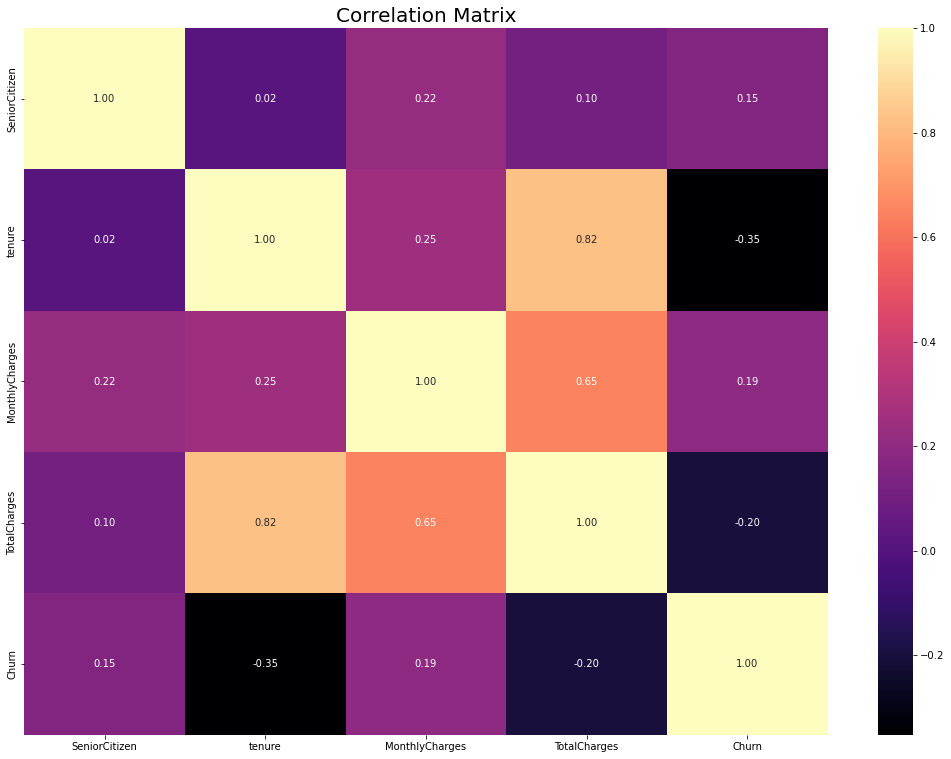

In [30]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [31]:
df["Average_monthly_charge"] = df["TotalCharges"] / df ["tenure"]

In [32]:
df.drop("Average_monthly_charge", axis = 1,inplace = True)

In [33]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [34]:
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [35]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_Engaged
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,1
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,1
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0


In [36]:
df.drop("Contract",axis = 1, inplace = True)

In [37]:
df["Count"] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']] != "No").sum(axis = 1)


In [38]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_Engaged,Count
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Yes,Electronic check,29.85,29.85,0,0,2
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,No,Mailed check,56.95,1889.50,0,1,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Yes,Mailed check,53.85,108.15,1,0,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,No,Bank transfer (automatic),42.30,1840.75,0,1,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Yes,Electronic check,70.70,151.65,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Mailed check,84.80,1990.50,0,1,7
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,Credit card (automatic),103.20,7362.90,0,1,6
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Yes,Electronic check,29.60,346.45,0,0,2
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Mailed check,74.40,306.60,1,0,2


In [39]:
cat_cols , num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 22
cat_cols: 18
num_cols: 3
cat_but_car: 1
num_but_cat: 4


In [40]:
cat_cols = [col for col in cat_cols if col != "Churn" ]

In [41]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]


In [42]:
binary_cols = [col for col in binary_cols if col != "Churn" ]

In [43]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


In [44]:
for col in binary_cols:
    df = label_encoder(df, col)

In [45]:
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'NEW_Engaged']

In [46]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_Engaged,Count
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,1,Electronic check,29.85,29.85,0,0,2
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,...,No,No,No,0,Mailed check,56.95,1889.50,0,1,4
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,...,No,No,No,1,Mailed check,53.85,108.15,1,0,4
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,No,No,0,Bank transfer (automatic),42.30,1840.75,0,1,4
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,1,Electronic check,70.70,151.65,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,Yes,DSL,Yes,...,Yes,Yes,Yes,1,Mailed check,84.80,1990.50,0,1,7
7039,2234-XADUH,0,0,1,1,72,1,Yes,Fiber optic,No,...,No,Yes,Yes,1,Credit card (automatic),103.20,7362.90,0,1,6
7040,4801-JZAZL,0,0,1,1,11,0,No phone service,DSL,Yes,...,No,No,No,1,Electronic check,29.60,346.45,0,0,2
7041,8361-LTMKD,1,1,1,0,4,1,Yes,Fiber optic,No,...,No,No,No,1,Mailed check,74.40,306.60,1,0,2


In [47]:
cat_cols = [col for col in cat_cols if col not in binary_cols]

In [48]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [49]:
df = one_hot_encoder(df, cat_cols)
    

In [50]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Count_2,Count_3,Count_4,Count_5,Count_6,Count_7,Count_8
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,1,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,0,0,1,0,0,1,0,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,0,0,1,0,0,1,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,0,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,1,84.80,1990.50,...,0,0,1,0,0,0,0,0,1,0
7039,2234-XADUH,0,0,1,1,72,1,1,103.20,7362.90,...,1,0,0,0,0,0,0,1,0,0
7040,4801-JZAZL,0,0,1,1,11,0,1,29.60,346.45,...,0,1,0,1,0,0,0,0,0,0
7041,8361-LTMKD,1,1,1,0,4,1,1,74.40,306.60,...,0,0,1,1,0,0,0,0,0,0


In [51]:
!pip install catboost
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")


In [52]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [53]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")



Accuracy: 0.79
Recall: 0.64
Precision: 0.51
F1: 0.57
Auc: 0.74


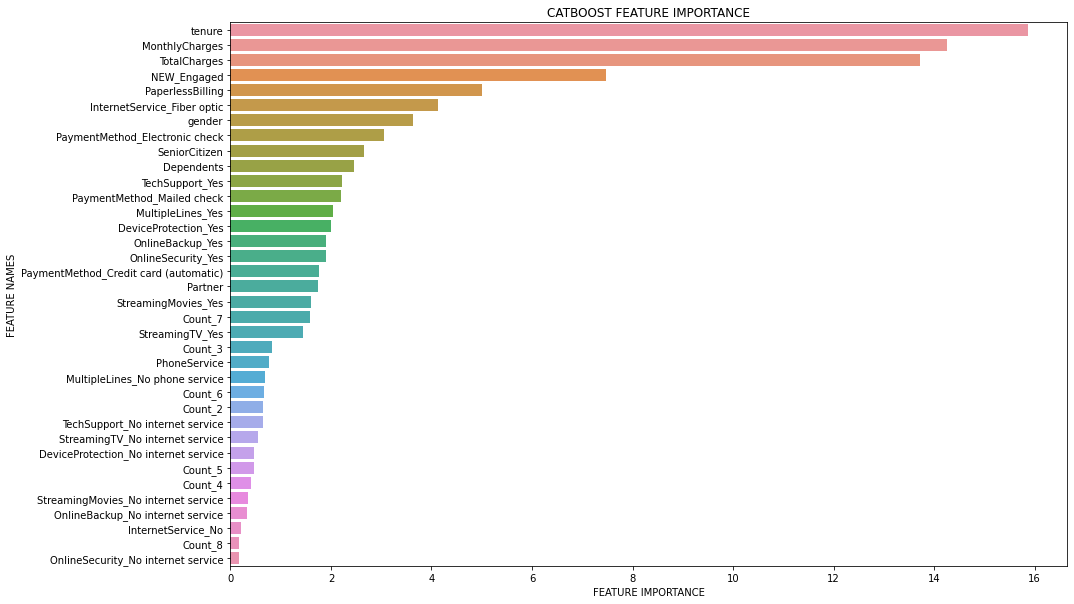

In [54]:
def plot_feature_importance(importance,names,model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(15, 10))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

plot_feature_importance(catboost_model.get_feature_importance(), X.columns, 'CATBOOST')

